In [1]:
!pip install forex-python

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import requests
import json
import time
import joblib
import datetime

from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import GridSearchCV
from sklearn import tree
from sklearn.preprocessing import StandardScaler

from forex_python.converter import CurrencyRates

###RandomizedSearchCV

from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score

In [3]:
def change_currency(val, curr_from, curr_to):
  if curr_from != curr_to:
    curr_from = curr_from.upper()
    curr_to = curr_to.upper()
    c = CurrencyRates()
    return round(val/c.get_rate(curr_to, curr_from, datetime.datetime.now()))

In [4]:
def remove_mark(value):
    marks = ['>', '<', '-', '+', '_', ' ', '  ', ',']
    for mark in marks:
        if pd.notna(value) and mark in value:
            return value.replace(mark, '')
    return value

In [5]:
def remove_blanc(value):
    if value == '':
        value = 0
        return value

In [6]:
def evaluate_regression_model(model, X_test, y_test):
    """
    Evaluates the performance of a regression model and provides a summary.

    Parameters:
        model: A trained regression model from scikit-learn.
        X_test: Test features.
        y_test: Test labels.
    """
    # Predictions on the test set
    y_pred = model.predict(X_test)

    # Calculate metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)  # RMSE
    r2 = r2_score(y_test, y_pred)

    # Display results
    print("Regression Model Evaluation:")
    print("===========================")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"R-squared (R2): {r2:.2f}")

In [7]:
def api_to_df(url):
    response = requests.get(url)
    content = response.json()
    return pd.DataFrame.from_records(content)


In [8]:
def to_csv_date(df, filename):
    current_date = pd.Timestamp("today").strftime("%m%d%Y")
    df.to_csv(filename + '_' + current_date + '_.csv', index = False)


In [9]:
def remove_null_col(df):
    return df.dropna(axis=1, how='all', inplace = False)

In [10]:
def flatten_list_col(df):
    new_df = pd.DataFrame()
    nested_columns_list = []
    for i, col in enumerate(df.columns):
        if any(isinstance(item, list) for item in df[col]):
            nested_columns_list.append(col)
            new_df= pd.concat([new_df, df[col].apply(pd.Series)], axis = 1)
    new_columns = list(range(len(new_df.columns)))
    new_df.columns = new_columns
    return new_df

In [11]:
def flatten_dict_col(df):
    new_df = pd.DataFrame()
    nested_columns_list = []
    for i, col in enumerate(df.columns):
        if any(isinstance(item, dict) for item in df[col]):
            nested_columns_list.append(col)
            new_df= pd.concat([new_df, df[col].apply(pd.Series)], axis = 1)
#     new_columns = list(range(len(new_df.columns)))
#     new_df.columns = new_columns
    new_df = remove_null_col(new_df)
    return new_df

In [12]:
def unpack_nested_col(nested_col, key_name):
    unpacked_col = {}
    nested_col_unpacked = nested_col.apply(pd.Series)
    for i, col in enumerate(nested_col_unpacked.columns):
        unpacked_col[f'{key_name}_{i}'] = nested_col_unpacked[col].apply(pd.Series)
        if 0 in unpacked_col[f'{key_name}_{i}'].columns:
            if unpacked_col[f'{key_name}_{i}'][0].isna().all():
                unpacked_col[f'{key_name}_{i}'].drop(columns = 0, inplace = True)
    return unpacked_col

In [13]:
def standardize_text(df, text_field):
    df[text_field] = df[text_field].str.lower()
    return df

In [14]:
def replace_cols(recipient_df, col_replaced, donor_df, col_replacing):
    recipient_df.drop(columns = col_replaced, inplace = True)
    recipient_df = pd.concat([recipient_df, donor_df[col_replacing]])
    return recipient_df

## Reading initial data from API. In this step, we accept all offers from the API, but only receive general information. In order to complete the data, we also read each offer separately using its individual API.


## Unpacking the data


In [15]:
df_init = api_to_df('https://justjoin.it/api/offers')

df_init.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12829 entries, 0 to 12828
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   title                    12829 non-null  object
 1   street                   12827 non-null  object
 2   city                     12829 non-null  object
 3   country_code             12824 non-null  object
 4   address_text             12829 non-null  object
 5   marker_icon              12829 non-null  object
 6   workplace_type           12829 non-null  object
 7   company_name             12829 non-null  object
 8   company_url              12829 non-null  object
 9   company_size             12829 non-null  object
 10  experience_level         12829 non-null  object
 11  latitude                 12829 non-null  object
 12  longitude                12829 non-null  object
 13  published_at             12829 non-null  object
 14  remote_interview         12829 non-nul

## Select the subset of the data - only "data" marker icon

In [16]:
# Limit observations to those that have flag 'data'
df_data = df_init[df_init['marker_icon'] == 'data']
df_data.reset_index(drop=True, inplace = True)

## Reading detailed data for every separete offer from API

In [17]:
json_data = []

In [18]:
offers = list(df_data.id)

In [19]:
len(offers)

1175

In [20]:
for offer in offers:
  url = f'https://justjoin.it/api/offers/{offer}'
  response = requests.get(url)
  json_obj = response.json()
#   initial_df = pd.json_normalize(json_obj)
  json_data.append(json_obj)
#   time.sleep(0.5)

In [21]:
df_data_offers = pd.DataFrame(json_data)
# to_csv_date(df_data_offers, 'df_data_offers')

In [22]:
df_data_offers.info(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1175 entries, 0 to 1174
Data columns (total 35 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   apply_body               0 non-null      object
 1   title                    1175 non-null   object
 2   street                   1175 non-null   object
 3   city                     1175 non-null   object
 4   country_code             1175 non-null   object
 5   address_text             1175 non-null   object
 6   marker_icon              1175 non-null   object
 7   workplace_type           1175 non-null   object
 8   company_name             1175 non-null   object
 9   company_url              1175 non-null   object
 10  company_size             1175 non-null   object
 11  experience_level         1175 non-null   object
 12  latitude                 1175 non-null   object
 13  longitude                1175 non-null   object
 14  apply_url                757 non-null   

### Dealing with skills

In [23]:
print(df_data_offers['skills'][0])

[{'name': 'Databases', 'level': 4}, {'name': 'English', 'level': 4}, {'name': 'Oracle', 'level': 4}, {'name': 'SQL Server', 'level': 3}, {'name': 'MySQL', 'level': 1}, {'name': 'MariaDB', 'level': 1}, {'name': 'Eloquence', 'level': 1}, {'name': 'AIX', 'level': 1}, {'name': 'Windows', 'level': 1}, {'name': 'DevOps', 'level': 1}]


In [24]:
# Putting all skills into one column

old_data = df_data_offers.to_dict(orient='records')
new_data = []

for index, skills_list in enumerate(df_data_offers['skills']):
    for skill in skills_list:
        new_row = old_data[index].copy()
        new_row['skill_name'] = skill['name']
        new_row['skill_level'] = skill['level']
        new_data.append(new_row)

In [25]:
new_df = pd.DataFrame(new_data)

In [26]:
new_df.sample()

,apply_body,title,street,city,country_code,address_text,marker_icon,workplace_type,company_name,company_url,...,body,company_logo_url,banner_url,skills,remote,employment_types,multilocation,company_profile,skill_name,skill_level
762,None,Data Engineer II - Fulfillment,Przy Rondzie 4,Kraków,PL,"Przy Rondzie 4, Kraków",data,partly_remote,Tesco Technology,https://www.linkedin.com/showcase/tesco-techno...,...,<div>\n<strong>Company Description</strong><br...,https://bucket.justjoin.it/offers/company_logo...,None,"[{'name': 'Hadoop', 'level': 4}, {'name': 'Sca...",False,"[{'type': 'b2b', 'salary': {'from': 20000, 'to...",[{'slug': 'tesco-technology-software-developme...,"{'url': '/brands/story/tesco-technology', 'sho...",Hadoop,4


In [27]:
new_df.skill_name.unique()

array(['Databases', 'English', 'Oracle', 'SQL Server', 'MySQL', 'MariaDB',
       'Eloquence', 'AIX', 'Windows', 'DevOps', 'German',
       'Software Engineering', 'Algorithms', 'Java', 'NodeJS', 'Mobile',
       'Python', 'Data Integration', 'Spark', 'ETL tools', 'AWS',
       'Hadoop', 'Kafka', 'NIFI', 'SQL', 'Azure', 'ETL', 'CI/CD',
       'Big Data', 'Cassandra', 'IoT', 'RabbitMQ', 'Snowflake', 'Agile',
       'R', 'Scala', 'Cloud', 'Data', 'Airflow', 'Terraform', 'Datadog',
       'Business Analysis', 'Private Capital fund industry',
       'Project Management', 'eFront', 'PostgreSQL',
       'Google Cloud Platform', 'Cloud SQL', 'Microservices',
       'Networking', 'BigQuery', 'Kubernetes', 'Docker',
       'Identity Management', 'virtualisation', 'secutity', 'Powershell',
       'VBScript', 'Graph API', 'MS', 'AD', 'MECM', 'MS/Postgre SQL',
       'Technologie Voice i eCom', 'Multifond', 'Arc Regulatory',
       'Fund ID', 'Arep', 'Oracle BI', 'PL/SQL', 'T-SQL', 'SAP', 'Bots',


In [28]:
new_df.skill_name.nunique()

501

In [29]:
# Po co to?

clean_df = new_df.copy()
clean_df = standardize_text(clean_df, "title")
clean_df = standardize_text(clean_df, "skill_name")

In [30]:
clean_df.head(5)

,apply_body,title,street,city,country_code,address_text,marker_icon,workplace_type,company_name,company_url,...,body,company_logo_url,banner_url,skills,remote,employment_types,multilocation,company_profile,skill_name,skill_level
0,None,database administrator,-,Warszawa,PL,"-, Warszawa",data,remote,Qurate Retail Group,http://QurateRetailGroup.com,...,<div>\n<strong>The Qurate Retail Group (QRG)</...,https://bucket.justjoin.it/offers/company_logo...,None,"[{'name': 'Databases', 'level': 4}, {'name': '...",True,"[{'type': 'permanent', 'salary': {'from': 1800...",[{'slug': 'qurate-retail-group-database-admini...,{'url': '/brands/story/qurate-retail-group-glo...,databases,4
1,None,database administrator,-,Warszawa,PL,"-, Warszawa",data,remote,Qurate Retail Group,http://QurateRetailGroup.com,...,<div>\n<strong>The Qurate Retail Group (QRG)</...,https://bucket.justjoin.it/offers/company_logo...,None,"[{'name': 'Databases', 'level': 4}, {'name': '...",True,"[{'type': 'permanent', 'salary': {'from': 1800...",[{'slug': 'qurate-retail-group-database-admini...,{'url': '/brands/story/qurate-retail-group-glo...,english,4
2,None,database administrator,-,Warszawa,PL,"-, Warszawa",data,remote,Qurate Retail Group,http://QurateRetailGroup.com,...,<div>\n<strong>The Qurate Retail Group (QRG)</...,https://bucket.justjoin.it/offers/company_logo...,None,"[{'name': 'Databases', 'level': 4}, {'name': '...",True,"[{'type': 'permanent', 'salary': {'from': 1800...",[{'slug': 'qurate-retail-group-database-admini...,{'url': '/brands/story/qurate-retail-group-glo...,oracle,4
3,None,database administrator,-,Warszawa,PL,"-, Warszawa",data,remote,Qurate Retail Group,http://QurateRetailGroup.com,...,<div>\n<strong>The Qurate Retail Group (QRG)</...,https://bucket.justjoin.it/offers/company_logo...,None,"[{'name': 'Databases', 'level': 4}, {'name': '...",True,"[{'type': 'permanent', 'salary': {'from': 1800...",[{'slug': 'qurate-retail-group-database-admini...,{'url': '/brands/story/qurate-retail-group-glo...,sql server,3
4,None,database administrator,-,Warszawa,PL,"-, Warszawa",data,remote,Qurate Retail Group,http://QurateRetailGroup.com,...,<div>\n<strong>The Qurate Retail Group (QRG)</...,https://bucket.justjoin.it/offers/company_logo...,None,"[{'name': 'Databases', 'level': 4}, {'name': '...",True,"[{'type': 'permanent', 'salary': {'from': 1800...",[{'slug': 'qurate-retail-group-database-admini...,{'url': '/brands/story/qurate-retail-group-glo...,mysql,1


In [31]:
top_values = clean_df['skill_name'].value_counts().head(20)
top_20_skills = list(top_values.index)

In [32]:
print(top_20_skills)

['sql', 'python', 'english', 'java', 'snowflake', 'power bi', 'azure', 'aws', 'etl', 'oracle', 'big data', 'machine learning', 'databases', 'sql server', 'agile', 'spark', 'devops', 'databricks', 'scala', 'cassandra']


In [33]:
with open('output.txt', 'w') as file:
    for item in top_20_skills:
        file.write(str(item) + '\n')

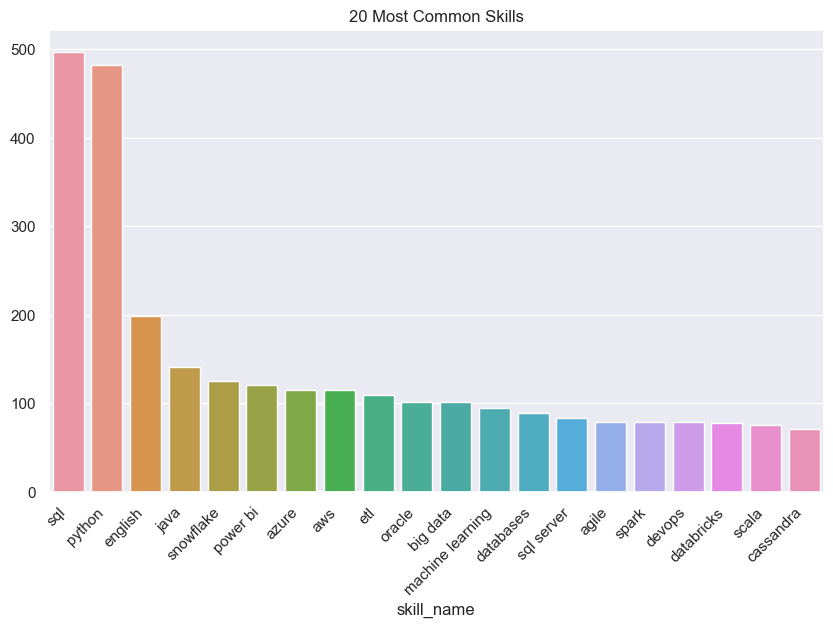

In [34]:
plt.figure(figsize=(10, 6))
sns.set(style="darkgrid")
plot = sns.barplot(x=clean_df['skill_name'].value_counts().iloc[:20].index, y=clean_df['skill_name'].value_counts().iloc[:20].values)
plot.set_title('20 Most Common Skills')
plot.set_xticklabels(plot.get_xticklabels(), rotation=45, horizontalalignment='right')

plt.show()

In [35]:
# Sprawdzanie i zamiana wartości
common_skills_df = clean_df.copy()
mask = ~common_skills_df['skill_name'].isin(top_20_skills)
common_skills_df.loc[mask, 'skill_name'] = None


In [36]:
most_common_skills_df = common_skills_df.dropna(subset=['skill_name'])

In [37]:
most_common_skills_df.reset_index(drop=True, inplace = True)
most_common_skills_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2836 entries, 0 to 2835
Data columns (total 37 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   apply_body               0 non-null      object
 1   title                    2836 non-null   object
 2   street                   2836 non-null   object
 3   city                     2836 non-null   object
 4   country_code             2836 non-null   object
 5   address_text             2836 non-null   object
 6   marker_icon              2836 non-null   object
 7   workplace_type           2836 non-null   object
 8   company_name             2836 non-null   object
 9   company_url              2836 non-null   object
 10  company_size             2836 non-null   object
 11  experience_level         2836 non-null   object
 12  latitude                 2836 non-null   object
 13  longitude                2836 non-null   object
 14  apply_url                1738 non-null  

In [38]:
most_common_skills_df.columns

Index(['apply_body', 'title', 'street', 'city', 'country_code', 'address_text',
       'marker_icon', 'workplace_type', 'company_name', 'company_url',
       'company_size', 'experience_level', 'latitude', 'longitude',
       'apply_url', 'published_at', 'remote_interview', 'video_key',
       'video_provider', 'open_to_hire_ukrainians', 'future_consent_title',
       'future_consent', 'information_clause', 'custom_consent_title',
       'custom_consent', 'id', 'tags', 'body', 'company_logo_url',
       'banner_url', 'skills', 'remote', 'employment_types', 'multilocation',
       'company_profile', 'skill_name', 'skill_level'],
      dtype='object')

In [39]:
dummies = pd.get_dummies(most_common_skills_df['skill_name'], prefix='skill')

for col in dummies.columns:
    dummies[col] *=  most_common_skills_df['skill_level']

# Dołączanie kolumn dummies
aggregated_df = pd.concat([most_common_skills_df, dummies], axis=1)

def custom_agg(series):
    if series.name.startswith('skill'):
        return series.sum()
    else:
        return series.iat[0]


aggregated_df = aggregated_df.drop('skill_name', axis=1)
aggregated_df = aggregated_df.drop('skills', axis=1)

# Grupowanie, agregacja i reset indeksu
aggregated_df = aggregated_df.groupby('id', as_index=False).agg(custom_agg)
aggregated_df = aggregated_df.drop('skill_level', axis=1)

In [40]:
aggregated_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1037 entries, 0 to 1036
Data columns (total 54 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   id                       1037 non-null   object
 1   apply_body               0 non-null      object
 2   title                    1037 non-null   object
 3   street                   1037 non-null   object
 4   city                     1037 non-null   object
 5   country_code             1037 non-null   object
 6   address_text             1037 non-null   object
 7   marker_icon              1037 non-null   object
 8   workplace_type           1037 non-null   object
 9   company_name             1037 non-null   object
 10  company_url              1037 non-null   object
 11  company_size             1037 non-null   object
 12  experience_level         1037 non-null   object
 13  latitude                 1037 non-null   object
 14  longitude                1037 non-null  

## Dealing with experience level - label encoding

In [41]:
aggregated_df['experience_level'].unique()

array(['junior', 'mid', 'senior'], dtype=object)

In [42]:
# label_encoder = preprocessing.LabelEncoder()
# aggregated_df['experience_level']= label_encoder.fit_transform(aggregated_df['experience_level'])
level_mapping = {'junior': 0, 'mid': 1, 'senior': 2}
aggregated_df['experience_level'] = aggregated_df['experience_level'].map(level_mapping)

In [43]:
aggregated_df['experience_level'].unique()

array([0, 1, 2])

## Dealing with 'workplace_type', 'country_code'

In [44]:
aggregated_df['workplace_type'].unique()

array(['partly_remote', 'remote', 'office'], dtype=object)

In [45]:
aggregated_df['country_code'].unique()

array(['PL', 'SK', 'CZ', 'HU', 'AT', 'SI', 'RO', 'US', 'ES', 'DE', 'GB'],
      dtype=object)

In [46]:
workplace_mapping= {'remote': 0, 'partly_remote': 1, 'office': 2}
country_mapping = {'PL': 0, 'SK': 1, 'CZ': 2, 'HU': 3, 'AT': 4, 'SI': 5, 'RO': 6, 'MT': 7, 'DE': 8, 'UA': 9, 'None': 10,
       'EE': 11}

aggregated_df['workplace_type'] =aggregated_df['workplace_type'].map(workplace_mapping)

aggregated_df['country_code'] = aggregated_df['country_code'].map(country_mapping)
aggregated_df['country_code'] = aggregated_df['country_code'].fillna(10)

## Dealing with salaries

In [47]:
df_employment_types = aggregated_df['employment_types'].apply(pd.Series)
df_employment_types.sample()

,0,1
502,"{'type': 'b2b', 'salary': {'from': 20000, 'to'...",NaN


In [48]:
df_employment_type_1 = df_employment_types[0].apply(pd.Series, dtype='object')
df_employment_type_1= pd.concat([df_employment_type_1.drop(['salary'], axis=1),
                                 df_employment_type_1['salary'].apply(pd.Series, dtype='object')], axis=1)
df_employment_type_1['type'].unique()

array(['b2b', 'permanent', 'mandate_contract'], dtype=object)

In [49]:
df_employment_type_2 = df_employment_types[1].apply(pd.Series, dtype='object')
df_employment_type_2 = pd.concat([df_employment_type_2.drop(['salary'], axis=1),
                                  df_employment_type_2['salary'].apply(pd.Series, dtype='object')], axis=1)
df_employment_type_2.drop(columns=0, inplace = True)
df_employment_type_2.sample(10)

,type,from,to,currency
990,permanent,27000.0,37000.0,pln
833,NaN,NaN,NaN,NaN
584,NaN,NaN,NaN,NaN
225,permanent,7000.0,14000.0,pln
843,b2b,NaN,NaN,NaN
354,NaN,NaN,NaN,NaN
968,NaN,NaN,NaN,NaN
664,NaN,NaN,NaN,NaN
998,permanent,27000.0,37000.0,pln
10,NaN,NaN,NaN,NaN


In [50]:
df_no_employment = aggregated_df.drop(columns = 'employment_types')
df_employment_1 = pd.concat([df_no_employment, df_employment_type_1], axis = 1)
df_employment_2 = pd.concat([df_no_employment, df_employment_type_2], axis = 1)
df_employment = pd.concat([df_employment_1, df_employment_2])
df_employment.dropna(subset=['type'], inplace = True)
df_employment.reset_index(drop=True, inplace = True)
df_employment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1225 entries, 0 to 1224
Data columns (total 57 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       1225 non-null   object 
 1   apply_body               0 non-null      object 
 2   title                    1225 non-null   object 
 3   street                   1225 non-null   object 
 4   city                     1225 non-null   object 
 5   country_code             1225 non-null   float64
 6   address_text             1225 non-null   object 
 7   marker_icon              1225 non-null   object 
 8   workplace_type           1225 non-null   int64  
 9   company_name             1225 non-null   object 
 10  company_url              1225 non-null   object 
 11  company_size             1225 non-null   object 
 12  experience_level         1225 non-null   int64  
 13  latitude                 1225 non-null   object 
 14  longitude               

In [51]:
# df_employment['type']= label_encoder.fit_transform(df_employment['type'])
type_map = {'permanent': 0, 'b2b': 1, 'mandate_contract': 2}
df_employment['type'] = df_employment['type'].map(type_map)

### Convert all currencies to PLN

In [52]:
currency_list = list(df_employment[df_employment['from'].notna()]['currency'].unique())
currency_list

['pln', 'eur', 'usd']

In [53]:
selected_currency  = 'pln'
foreign_currencies = currency_list.copy()
foreign_currencies.remove(selected_currency)

In [54]:
df_with_salary = df_employment[df_employment['currency'].notna()]
df_no_salary = df_employment[df_employment['currency'].isna()]

In [55]:
df_with_salary['from'] = df_with_salary.apply(lambda row: change_currency(row['from'], row['currency'], selected_currency)
                                              if row['currency'] != selected_currency and pd.notna(row['currency'])
                                              else row['from'], axis=1)

/var/folders/mp/mpgc14lx6b9f41xmhqs4mxc80000gn/T/ipykernel_97379/2430910949.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_with_salary['from'] = df_with_salary.apply(lambda row: change_currency(row['from'], row['currency'], selected_currency)


In [56]:
df_with_salary['to'] = df_with_salary.apply(lambda row: change_currency(row['to'], row['currency'], selected_currency)
                                            if row['currency'] != selected_currency and pd.notna(row['currency'])
                                            else row['to'], axis=1)

/var/folders/mp/mpgc14lx6b9f41xmhqs4mxc80000gn/T/ipykernel_97379/1341338040.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_with_salary['to'] = df_with_salary.apply(lambda row: change_currency(row['to'], row['currency'], selected_currency)


In [57]:
df_with_salary.loc[df_with_salary['currency'] != selected_currency, 'currency'] = selected_currency

In [58]:
df_pln = pd.concat([df_with_salary, df_no_salary])
df_pln.reset_index(drop=True, inplace = True)
df_pln.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1225 entries, 0 to 1224
Data columns (total 57 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       1225 non-null   object 
 1   apply_body               0 non-null      object 
 2   title                    1225 non-null   object 
 3   street                   1225 non-null   object 
 4   city                     1225 non-null   object 
 5   country_code             1225 non-null   float64
 6   address_text             1225 non-null   object 
 7   marker_icon              1225 non-null   object 
 8   workplace_type           1225 non-null   int64  
 9   company_name             1225 non-null   object 
 10  company_url              1225 non-null   object 
 11  company_size             1225 non-null   object 
 12  experience_level         1225 non-null   int64  
 13  latitude                 1225 non-null   object 
 14  longitude               

at this stage df includes:
- offers with marker icon 'data'
- ordered employment column
- cleaned company_size column
- selected offers with the 30 most popular skills among 'data', both with given and unknown salary
- experience_level, country_code, employment_type, workplace_type and skills encoded columns
- offers in a foreign currency converted into PLN

In [59]:
#cleaning up and encoding company sizes

#cleaning up sizes that contain '-'
company_size_df = df_pln[df_pln['company_size'].str.contains('-')][['company_size']]
company_size_df

,company_size
5,11-50
31,51-200
32,51-200
33,51-200
34,51-200
...,...
1014,1-600
1015,1-600
1016,1-600
1017,1-600


In [60]:
company_size_df['company_size_1'] = company_size_df['company_size'].str.split('-').str[0]
company_size_df['company_size_2']  = company_size_df['company_size'].str.split('-').str[-1]

In [61]:
company_size_df[company_size_df['company_size']=='-']

,company_size,company_size_1,company_size_2


In [62]:
company_size_df = company_size_df[company_size_df['company_size'] != '-']
company_size_df[company_size_df['company_size']=='-']

,company_size,company_size_1,company_size_2


In [63]:
# company_size_df = company_size_df.copy()
company_size_df['company_size_1'] = pd.to_numeric(company_size_df['company_size_1'])
company_size_df['company_size_2'] = pd.to_numeric(company_size_df['company_size_2'])
company_size_df['avg_company_size'] = (company_size_df['company_size_1'] + company_size_df['company_size_2']) / 2

company_size_df = company_size_df[['avg_company_size']]
company_size_df

,avg_company_size
5,30.5
31,125.5
32,125.5
33,125.5
34,125.5
...,...
1014,300.5
1015,300.5
1016,300.5
1017,300.5


In [64]:
df_avg_company_size = pd.merge(df_pln, company_size_df, left_index=True, right_index=True, how = 'outer')

In [65]:
df_avg_company_size['company_size'] = df_avg_company_size['company_size'].apply(remove_mark)
df_avg_company_size['company_size'].unique()

array(['250', '6000', '1150', '200', '30', '51200', '1001  5000', '150',
       '100', '500', '6080', '60000', '1000', '2030', '50', '300000',
       '16', '120', '5000', '1020', '7080', '3040', '450', '40', '1400',
       '1530', '5011000', '750', '350', '80', '101500', '50100', '60',
       '63', '200250', '50  100', '2000', '600', '650', '900', '460',
       '430', '300', '230', '60  70', '2650', '22 200', '3060', '30000',
       '170 ', '1525', ' 30', '1500', '280', '2 000', '100200', '51100',
       '170', '8600', '500 000', '70100', '9000', '1700', '250350', '400',
       '700', '100 000', '635', '7000', '10000', '1600', '4500', '1300',
       '800', '3000', ' 6 500 ', '22000', '3500', '25'], dtype=object)

In [66]:
df_avg_company_size['company_size'] = df_avg_company_size['company_size'].apply(remove_mark)
df_avg_company_size['company_size'].unique()

array(['250', '6000', '1150', '200', '30', '51200', '10015000', '150',
       '100', '500', '6080', '60000', '1000', '2030', '50', '300000',
       '16', '120', '5000', '1020', '7080', '3040', '450', '40', '1400',
       '1530', '5011000', '750', '350', '80', '101500', '50100', '60',
       '63', '200250', '2000', '600', '650', '900', '460', '430', '300',
       '230', '6070', '2650', '22200', '3060', '30000', '170', '1525',
       '1500', '280', '100200', '51100', '8600', '500000', '70100',
       '9000', '1700', '250350', '400', '700', '100000', '635', '7000',
       '10000', '1600', '4500', '1300', '800', '3000', '6500', '22000',
       '3500', '25'], dtype=object)

In [67]:
df_avg_company_size['company_size'] = pd.to_numeric(df_avg_company_size['company_size'])

In [68]:
df_avg_company_size['avg_company_size'] = df_avg_company_size.apply(
    lambda row: row['company_size'] if pd.isna(row['avg_company_size']) else row['avg_company_size'],
    axis=1
).astype('float')

In [69]:
df_avg_company_size.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1225 entries, 0 to 1224
Data columns (total 58 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       1225 non-null   object 
 1   apply_body               0 non-null      object 
 2   title                    1225 non-null   object 
 3   street                   1225 non-null   object 
 4   city                     1225 non-null   object 
 5   country_code             1225 non-null   float64
 6   address_text             1225 non-null   object 
 7   marker_icon              1225 non-null   object 
 8   workplace_type           1225 non-null   int64  
 9   company_name             1225 non-null   object 
 10  company_url              1225 non-null   object 
 11  company_size             1225 non-null   int64  
 12  experience_level         1225 non-null   int64  
 13  latitude                 1225 non-null   object 
 14  longitude                1225

In [70]:
# to_csv_date(df_avg_company_size,'offers_API_ready_to_analyze')

# BUILDING REGRESSION MODEL

In [71]:
df_reg = df_avg_company_size.copy()
#pd.read_csv('https://raw.githubusercontent.com/KKozakiewicz/predict_salaries/main/ready_to_analyze_08252023_.csv')

In [72]:
df_reg.sample(5)

,id,apply_body,title,street,city,country_code,address_text,marker_icon,workplace_type,company_name,...,skill_scala,skill_snowflake,skill_spark,skill_sql,skill_sql server,type,from,to,currency,avg_company_size
374,inter-cars-s-a-data-analyst,None,data analyst,Zgrupowania AK Kampinos 15,Warszawa,0.0,"Zgrupowania AK Kampinos 15, Warszawa",data,0,Inter Cars S.A.,...,0,0,0,4,0,1,19000.0,25000.0,pln,1000.0
81,bayer-sp-z-o-o-data-engineer-wolomin,None,data engineer,-,Wołomin,0.0,"-, Wołomin",data,1,Bayer Sp. z o.o.,...,0,0,0,0,0,0,14000.0,20500.0,pln,100.0
644,sky-gate-machine-learning-developer-warszawa,None,machine learning developer,Centrum,Warszawa,0.0,"Centrum, Warszawa",data,0,Mindpal,...,0,0,0,0,0,1,13000.0,24000.0,pln,75.0
921,accenture-machine-learning-engineer-d1c3934c-3...,None,machine learning engineer,ul. Sienna 39,Warszawa,0.0,"ul. Sienna 39, Warszawa",data,1,Accenture,...,0,0,1,4,0,0,NaN,NaN,NaN,8600.0
954,bluesoft-data-engineer-gdansk,None,data engineer,Remote,Gdańsk,0.0,"Remote, Gdańsk",data,0,BlueSoft,...,0,0,0,0,0,1,NaN,NaN,NaN,1000.0


In [73]:
# remove columns that won't be taken into consideration
df_reg_limit=df_reg.drop(columns = ['id', 'apply_body', 'title', 'company_size', 'street', 'city', 'address_text', 'marker_icon', 'company_name', 'company_url', 'latitude', 'longitude', 'apply_url', 'published_at', 'remote_interview', 'video_key', 'video_provider', 'open_to_hire_ukrainians', 'future_consent_title', 'future_consent', 'information_clause', 'custom_consent_title', 'custom_consent', 'tags', 'body', 'company_logo_url', 'banner_url', 'multilocation', 'company_profile', 'currency'])


In [74]:
df_reg_limit.head()

,country_code,workplace_type,experience_level,remote,skill_agile,skill_aws,skill_azure,skill_big data,skill_cassandra,skill_databases,...,skill_python,skill_scala,skill_snowflake,skill_spark,skill_sql,skill_sql server,type,from,to,avg_company_size
0,0.0,0,2,True,0,3,0,0,0,0,...,4,0,3,1,4,0,1,31000.0,38000.0,250.0
1,0.0,0,2,True,0,3,0,0,0,0,...,4,0,3,1,4,0,1,25000.0,30000.0,250.0
2,0.0,0,1,True,0,0,0,0,0,0,...,4,0,0,0,4,0,0,13000.0,25000.0,6000.0
3,0.0,0,1,True,0,0,0,0,0,0,...,4,0,0,0,4,0,0,13000.0,25000.0,6000.0
4,0.0,0,1,True,0,0,0,0,0,0,...,4,0,0,0,4,0,0,13000.0,25000.0,6000.0


In [75]:
df_reg_limit.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1225 entries, 0 to 1224
Data columns (total 28 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   country_code            1225 non-null   float64
 1   workplace_type          1225 non-null   int64  
 2   experience_level        1225 non-null   int64  
 3   remote                  1225 non-null   bool   
 4   skill_agile             1225 non-null   int64  
 5   skill_aws               1225 non-null   int64  
 6   skill_azure             1225 non-null   int64  
 7   skill_big data          1225 non-null   int64  
 8   skill_cassandra         1225 non-null   int64  
 9   skill_databases         1225 non-null   int64  
 10  skill_databricks        1225 non-null   int64  
 11  skill_devops            1225 non-null   int64  
 12  skill_english           1225 non-null   int64  
 13  skill_etl               1225 non-null   int64  
 14  skill_java              1225 non-null   int64

In [76]:
# extract rows with no salary information
df_no_salaries = df_reg_limit[df_reg_limit['to'].isna()].reset_index(drop=True)
df_no_salaries.info()

# extract rows with salary information
df_salaries = df_reg_limit[df_reg_limit['to'].notna()].reset_index(drop=True)
df_salaries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 332 entries, 0 to 331
Data columns (total 28 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   country_code            332 non-null    float64
 1   workplace_type          332 non-null    int64  
 2   experience_level        332 non-null    int64  
 3   remote                  332 non-null    bool   
 4   skill_agile             332 non-null    int64  
 5   skill_aws               332 non-null    int64  
 6   skill_azure             332 non-null    int64  
 7   skill_big data          332 non-null    int64  
 8   skill_cassandra         332 non-null    int64  
 9   skill_databases         332 non-null    int64  
 10  skill_databricks        332 non-null    int64  
 11  skill_devops            332 non-null    int64  
 12  skill_english           332 non-null    int64  
 13  skill_etl               332 non-null    int64  
 14  skill_java              332 non-null    in

In [77]:
df_salaries_sorted = df_salaries.sort_values(by='from', ascending=True)
df_salaries_sorted.head()

,country_code,workplace_type,experience_level,remote,skill_agile,skill_aws,skill_azure,skill_big data,skill_cassandra,skill_databases,...,skill_python,skill_scala,skill_snowflake,skill_spark,skill_sql,skill_sql server,type,from,to,avg_company_size
800,0.0,2,0,False,0,0,0,0,0,0,...,0,0,0,0,1,0,0,3600.0,5090.0,75.0
519,0.0,1,0,False,0,0,0,0,0,0,...,1,0,0,0,3,0,0,4000.0,8000.0,460.0
441,0.0,1,0,False,0,0,0,0,0,0,...,0,0,0,0,3,0,0,4000.0,7000.0,25.0
411,0.0,2,0,False,0,0,0,0,0,0,...,0,0,0,0,1,0,1,4337.0,6133.0,75.0
706,0.0,0,0,True,0,0,0,0,0,0,...,0,0,0,0,2,0,2,4500.0,5000.0,1000.0


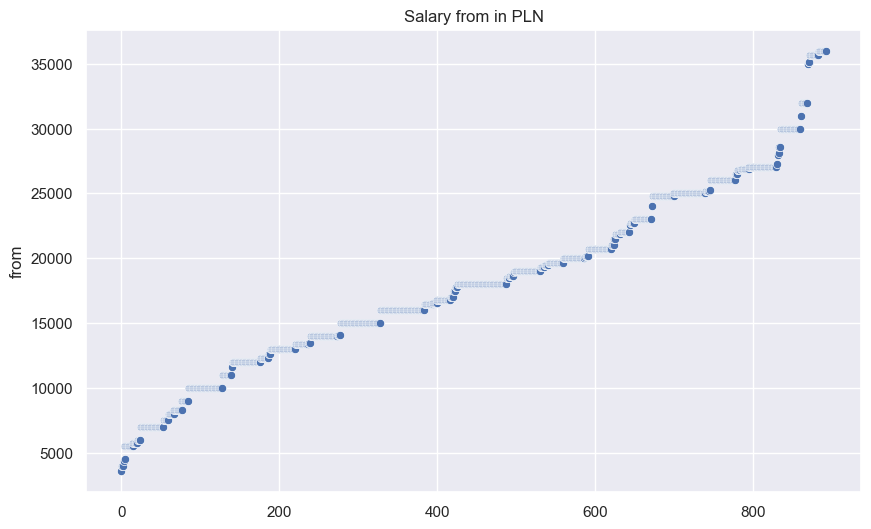

In [78]:
plt.figure(figsize=(10, 6))
sns.set(style="darkgrid")
plot = sns.scatterplot(x=np.arange(len(df_salaries_sorted)), y=df_salaries_sorted['from'])
plot.set_title('Salary from in PLN')

plt.show()

In [106]:
# split the dataset into training and test sets, now only salary_from is investigated
X = df_salaries.drop(columns=['from','to'])
y = df_salaries[['from', 'to']]

In [107]:
X['country_code'].unique()

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6., 10.,  8.])

In [108]:
import sklearn
scikit_version = sklearn.__version__
print(scikit_version)

1.2.2


In [109]:
# normalizing the data
scl = StandardScaler()
X_scaled = pd.DataFrame(scl.fit_transform(X), columns = X.columns)

In [110]:
joblib.dump(scl, f"Standard_Scaler_{scikit_version}.pkl")

['Standard_Scaler_1.2.2.pkl']

In [111]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

In [112]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 571 entries, 553 to 789
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   country_code            571 non-null    float64
 1   workplace_type          571 non-null    float64
 2   experience_level        571 non-null    float64
 3   remote                  571 non-null    float64
 4   skill_agile             571 non-null    float64
 5   skill_aws               571 non-null    float64
 6   skill_azure             571 non-null    float64
 7   skill_big data          571 non-null    float64
 8   skill_cassandra         571 non-null    float64
 9   skill_databases         571 non-null    float64
 10  skill_databricks        571 non-null    float64
 11  skill_devops            571 non-null    float64
 12  skill_english           571 non-null    float64
 13  skill_etl               571 non-null    float64
 14  skill_java              571 non-null    float

## Salafry_from: Random Forest + GridSeachCV

In [113]:
# select X and y
y_train_from = y_train['from']

# Initialize the RandomForestRegressor model
rf_regressor = RandomForestRegressor()

# Define the parameter grid for the grid search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a GridSearchCV object
gs_from = GridSearchCV(estimator=rf_regressor, param_grid=param_grid, cv=5, n_jobs=-1, scoring='neg_mean_absolute_error')

# Fit the GridSearchCV object to the training data
gs_from.fit(X_train, y_train_from)

# Get the best model with tuned hyperparameters
best_model_from = gs_from.best_estimator_

# Print best parameters
print("Best Parameters:", gs_from.best_params_)

# Predict on the test set
y_pred_from = best_model_from.predict(X_val)

# Evaluate the best model
evaluate_regression_model(best_model_from, X_val, y_val['from'])

Best Parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Regression Model Evaluation:
Mean Absolute Error (MAE): 764.47
Mean Squared Error (MSE): 3804075.23
Root Mean Squared Error (RMSE): 1950.40
R-squared (R2): 0.92


### Salary_from: comparision of real and predicted y for train and test set

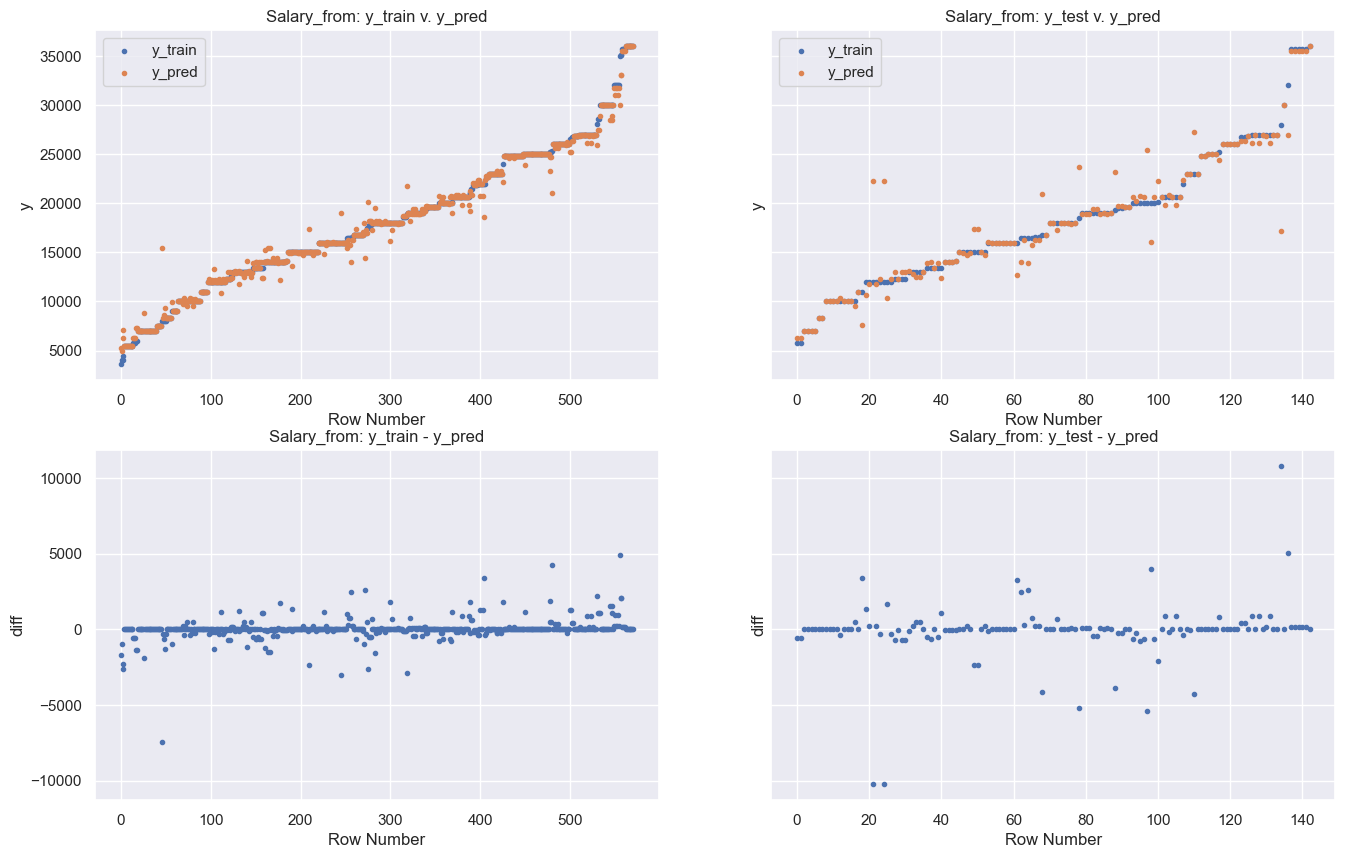

In [118]:
# df with real and predicted y for the train set
y_pred_train_from = best_model_from.predict(X_train)
df_train_from = {'y_train': y_train_from, 'y_pred_train': y_pred_train_from, 'train_diff': y_train_from-y_pred_train_from}
df_train_from = pd.DataFrame(df_train_from)
df_train_from.sort_values(by = 'y_train', inplace = True)

# df with real and predicted y for the test set
y_pred_test_from = best_model_from.predict(X_val)
df_test_from = {'y_test': y_val['from'], 'y_pred_test': y_pred_test_from, 'test_diff': y_val['from']-y_pred_test_from}
df_test_from = pd.DataFrame(df_test_from)
df_test_from.sort_values(by = 'y_test', inplace = True)

# plot
figure, axis = plt.subplots(2, 2, figsize=(16, 10), sharey = 'row')

length_train_from = range(len(df_train_from))
length_test_from = range(len(df_test_from))

# Salary_from: y_train v. y_pred
axis[0, 0].scatter(length_train_from, df_train_from['y_train'], marker = '.', label = 'y_train')
axis[0, 0].scatter(length_train_from, df_train_from['y_pred_train'], marker = '.', label = 'y_pred')
axis[0, 0].legend()
axis[0, 0].set_title("Salary_from: y_train v. y_pred")
axis[0, 0].set_xlabel('Row Number')
axis[0, 0].set_ylabel('y')

# Salary_from: y_train - y_pred
axis[1, 0].scatter(length_train_from, df_train_from['train_diff'], marker = '.')
axis[1, 0].set_title("Salary_from: y_train - y_pred")
axis[1, 0].set_xlabel('Row Number')
axis[1, 0].set_ylabel('diff')

# Salary_from: y_test v. y_pred
axis[0, 1].scatter(length_test_from, df_test_from['y_test'], marker = '.', label = 'y_train')
axis[0, 1].scatter(length_test_from, df_test_from['y_pred_test'], marker = '.', label = 'y_pred')
axis[0, 1].legend()
axis[0, 1].set_title("Salary_from: y_test v. y_pred")
axis[0, 1].set_xlabel('Row Number')
axis[0, 1].set_ylabel('y')

# Salary_from: y_test - y_pred
axis[1, 1].scatter(length_test_from, df_test_from['test_diff'], marker = '.')
axis[1, 1].set_title("Salary_from: y_test - y_pred")
axis[1, 1].set_xlabel('Row Number')
axis[1, 1].set_ylabel('diff')

plt.show()

### Salary_to: Random Forest + **GridSearchCV**

In [119]:
# select X and y
y_train_to = y_train['to']

# Initialize the RandomForestRegressor model
rf_regressor = RandomForestRegressor()

# Define the parameter grid for the grid search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a GridSearchCV object
gs_to = GridSearchCV(estimator=rf_regressor, param_grid=param_grid, cv=5, n_jobs=-1, scoring='neg_mean_absolute_error')

# Fit the GridSearchCV object to the training data
gs_to.fit(X_train, y_train_to)

# Get the best model with tuned hyperparameters
best_model_to = gs_to.best_estimator_

# Print best parameters
print("Best Parameters:", gs_to.best_params_)

# Evaluate the best model
evaluate_regression_model(best_model_to, X_val, y_val['to'])

Best Parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Regression Model Evaluation:
Mean Absolute Error (MAE): 969.52
Mean Squared Error (MSE): 5290141.75
Root Mean Squared Error (RMSE): 2300.03
R-squared (R2): 0.92


### Salary_to: comparision of real and predicted y for train and test set

KeyError: 'y_test'

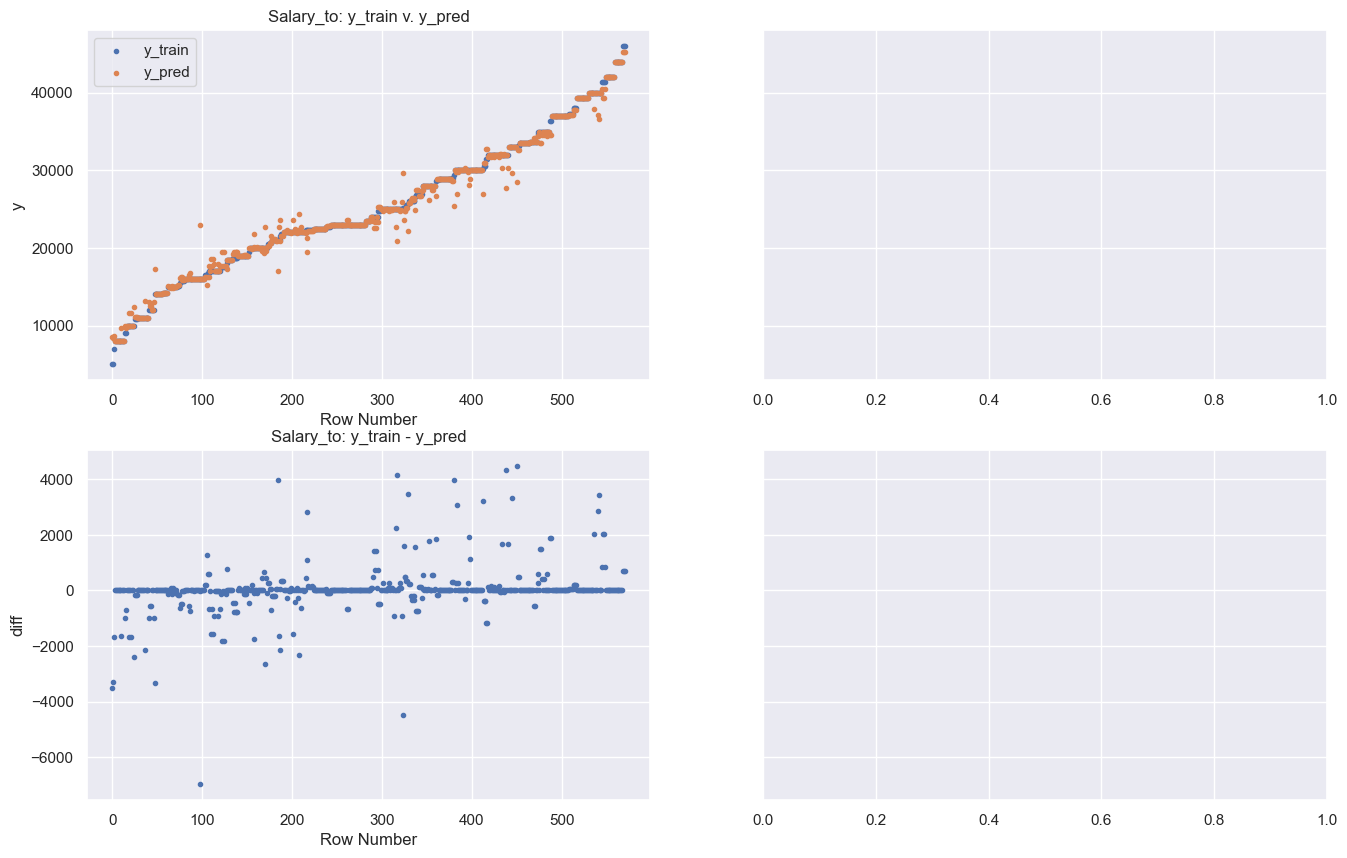

In [120]:
# # df with real and predicted y for the train set
# y_pred_train_to = best_model_to.predict(X_train)
# df_train_to = {'y_train': y_train_to, 'y_pred_train': y_pred_train_to, 'train_diff': y_train_to-y_pred_train_to}
# df_train_to = pd.DataFrame(df_train_to)
# df_train_to.sort_values(by = 'y_train', inplace = True)

# # df with real and predicted y for the test set
# y_pred_test_to = best_model_to.predict(X_val)
# df_test_to = {'y_val': y_val['to'], 'y_pred_test': y_pred_test_to, 'val_diff': y_val['to']-y_pred_test_to}
# df_test_to = pd.DataFrame(df_test_to)
# df_test_to.sort_values(by = 'y_val', inplace = True)

# # plot
# figure, axis = plt.subplots(2, 2, figsize=(16, 10), sharey = 'row')

# length_train_to = range(len(df_train_to))
# length_test_to = range(len(df_test_to))

# # Salary_to: y_train v. y_pred
# axis[0, 0].scatter(length_train_to, df_train_to['y_train'], marker = '.', label = 'y_train')
# axis[0, 0].scatter(length_train_to, df_train_to['y_pred_train'], marker = '.', label = 'y_pred')
# axis[0, 0].legend()
# axis[0, 0].set_title("Salary_to: y_train v. y_pred")
# axis[0, 0].set_xlabel('Row Number')
# axis[0, 0].set_ylabel('y')

# # Salary_to: y_train - y_pred
# axis[1, 0].scatter(length_train_to, df_train_to['train_diff'], marker = '.')
# axis[1, 0].set_title("Salary_to: y_train - y_pred")
# axis[1, 0].set_xlabel('Row Number')
# axis[1, 0].set_ylabel('diff')

# # Salary_to: y_test v. y_pred
# axis[0, 1].scatter(length_test_to, df_test_to['y_test'], marker = '.', label = 'y_train')
# axis[0, 1].scatter(length_test_to, df_test_to['y_pred_test'], marker = '.', label = 'y_pred')
# axis[0, 1].legend()
# axis[0, 1].set_title("Salary_to: y_test v. y_pred")
# axis[0, 1].set_xlabel('Row Number')
# axis[0, 1].set_ylabel('y')

# # Salary_to: y_test - y_pred
# axis[1, 1].scatter(length_test_to, df_test_to['test_diff'], marker = '.')
# axis[1, 1].set_title("Salary_to: y_test - y_pred")
# axis[1, 1].set_xlabel('Row Number')
# axis[1, 1].set_ylabel('diff')

# plt.show()

##MAE distribution

In [88]:
# mae_from = []

# for i in range(1000):

#     model_from = RandomForestRegressor(max_depth = None, min_samples_leaf= 1, min_samples_split= 2, n_estimators= 300)
#     # model_from = RandomForestRegressor(best_model_from.get_params())
#     model_from.fit(X_train_from, y_train_from)

#     mae_from.append(mean_absolute_error(y_test_from, model_from.predict(X_test_from)))

# sns.set_style("darkgrid")
# sns.histplot(mae_from)

In [ ]:
# from sklearn import model_selection
# mae_to = []

# for i in range(1000):

#     model_to = RandomForestRegressor(max_depth = 20, min_samples_leaf= 1, min_samples_split= 2, n_estimators= 100)
#     # model_to = RandomForestRegressor(best_model_to.get_params())
#     model_to.fit(X_train_to, y_train_to)

#     mae_to.append(mean_absolute_error(y_test_to, model_to.predict(X_test_to)))

# sns.set_style("darkgrid")
# sns.histplot(mae_to)

In [121]:
# saving model
import sklearn
scikit_version = sklearn.__version__
print(scikit_version)

joblib.dump(best_model_from, f"best_model_from_{scikit_version}.pkl")
joblib.dump(best_model_to, f"best_model_to_{scikit_version}.pkl")

1.2.2


['best_model_to_1.2.2.pkl']

# Reading job offer and preparing the data

In [138]:
job_offer = 'https://justjoin.it/offers/itds-machine-learning-engineer'
job_offer_api = job_offer.replace("https://justjoin.it/offers/", "https://justjoin.it/api/offers/")

In [139]:
response = requests.get(job_offer_api)
job_data = response.json()

In [140]:
with open('output.txt', 'r') as file:
    lines = file.readlines()
    top_20_skills = [line.strip() for line in lines]

print(top_20_skills)

['sql', 'python', 'english', 'java', 'snowflake', 'power bi', 'azure', 'aws', 'etl', 'oracle', 'big data', 'machine learning', 'databases', 'sql server', 'agile', 'spark', 'devops', 'databricks', 'scala', 'cassandra']


In [141]:
offer_data = []

for skill in job_data['skills']:
    # print(skill['name'])
    new_row = job_data.copy()
    new_row['skill_name'] = skill['name']
    new_row['skill_level'] = skill['level']
    offer_data.append(new_row)


offer_df = pd.DataFrame(offer_data)
offer_df = standardize_text(offer_df, "title")
offer_df = standardize_text(offer_df, "skill_name")

offer_dummies = pd.DataFrame()

for col_name in sorted(top_20_skills):
    offer_dummies["skill_" + col_name] = 0

offer_dummies.loc[0] = 0

In [142]:
final = []
for skill in offer_df['skill_name']:
    new_dummy = offer_dummies.copy()
    if skill in top_20_skills:
        new_dummy[f"skill_{skill}"] = 1
    final.append(new_dummy)

all_dummies = pd.concat(final, ignore_index=True)

In [143]:
for col in all_dummies.columns:
    all_dummies[col] *=  offer_df['skill_level']

# Dołączanie kolumn dummies
aggregated_offer_df = pd.concat([offer_df, all_dummies], axis=1)

def custom_agg(series):
    if series.name.startswith('skill'):
        return series.sum()
    else:
        return series.iat[0]


aggregated_offer_df = aggregated_offer_df.drop('skill_name', axis=1)
aggregated_offer_df = aggregated_offer_df.drop('skills', axis=1)

# Grupowanie, agregacja i reset indeksu
aggregated_offer_df = aggregated_offer_df.groupby('id', as_index=False).agg(custom_agg)
aggregated_offer_df = aggregated_offer_df.drop('skill_level', axis=1)

level_mapping = {'junior': 0, 'mid': 1, 'senior': 2}
workplace_mapping= {'remote': 0, 'partly_remote': 1, 'office': 2}
country_mapping = {'PL': 0, 'SK': 1, 'CZ': 2, 'HU': 3, 'AT': 4, 'SI': 5, 'RO': 6, 'MT': 7, 'DE': 8, 'UA': 9, 'None': 10,
       'EE': 11}

aggregated_offer_df['experience_level'] = aggregated_offer_df['experience_level'].map(level_mapping)

aggregated_offer_df['workplace_type'] =aggregated_offer_df['workplace_type'].map(workplace_mapping)

aggregated_offer_df['country_code'] = aggregated_offer_df['country_code'].map(country_mapping)
aggregated_df['country_code'] = aggregated_df['country_code'].fillna(10)

offer_employment_types = aggregated_offer_df['employment_types'].apply(pd.Series)
offer_employment_type = offer_employment_types[0].apply(pd.Series)
offer_employment_type= pd.concat([offer_employment_type.drop(['salary'], axis=1),
                                 offer_employment_type['salary'].apply(pd.Series)], axis=1)

offer_no_employment = aggregated_offer_df.drop(columns = 'employment_types')
offer_employment = pd.concat([offer_no_employment, offer_employment_type], axis = 1)

type_map = {'permanent': 0, 'b2b': 1, 'mandate_contract': 2}
offer_employment['type'] = offer_employment['type'].map(type_map)

In [144]:
offer_employment['company_size'][0]

'200+'

In [145]:
def standardize_company_size(company_size_value):
    company_size_value = str(company_size_value)
    if (company_size_value == '-' or company_size_value == '' or company_size_value == ' ' or company_size_value == 'None'):
        size = 0.0
    elif '-' in company_size_value:
        min_value, max_value = company_size_value.split('-')
        size = 0.5 * (float(min_value) + float(max_value))
    elif '+' in company_size_value:
        size = float(company_size_value.replace('+', ''))
    elif ' ' in company_size_value:
        size = float(company_size_value.replace(' ', ''))
    else:
        size = float(company_size_value)

    return size

In [146]:
offer_employment['avg_company_size'] = offer_employment['company_size'].apply(lambda x: standardize_company_size(x))

offer=offer_employment.drop(columns = ['id', 'from', 'to', 'currency','company_size', 'company_profile','apply_body', 'title', 'street', 'city', 'address_text', 'marker_icon', 'company_name', 'company_url', 'latitude', 'longitude', 'apply_url', 'published_at', 'remote_interview', 'video_key', 'video_provider', 'open_to_hire_ukrainians', 'future_consent_title', 'future_consent', 'information_clause', 'custom_consent_title', 'custom_consent', 'tags', 'body', 'company_logo_url', 'banner_url', 'multilocation'], errors='ignore')
scaler = joblib.load('Standard_Scaler_1.2.2.pkl')
offer_scaled = pd.DataFrame(scl.transform(offer), columns = offer.columns)

In [147]:
offer

,country_code,workplace_type,experience_level,remote,skill_agile,skill_aws,skill_azure,skill_big data,skill_cassandra,skill_databases,...,skill_oracle,skill_power bi,skill_python,skill_scala,skill_snowflake,skill_spark,skill_sql,skill_sql server,type,avg_company_size
0,0,1,2,False,0,0,0,0,0,0,...,0,0,3,0,0,1,0,0,1,200.0


In [148]:
# Predict on the test set
pred_from = best_model_from.predict(offer_scaled)
pred_to = best_model_to.predict(offer_scaled)

In [149]:
print(pred_from)
print(pred_to)

[21805.9]
[29691.97]


In [150]:
'''
company size, from, to i inne, tylko, jeeli faktycznie istnieją w dataframe
NaN w country code jeśli nan to 0
'''

'\ncompany size, from, to i inne, tylko, jeeli faktycznie istnieją w dataframe\nNaN w country code jeśli nan to 0\n'